In [1]:
# loading a dataset from pytorch
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional
from torch import nn

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# simply call dataset
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root = 'data',
    train=False,
    download=True,
    transform=transform
)

print(len(train_data))
# B, Type, Tensor

60000


torch.Size([28, 28])


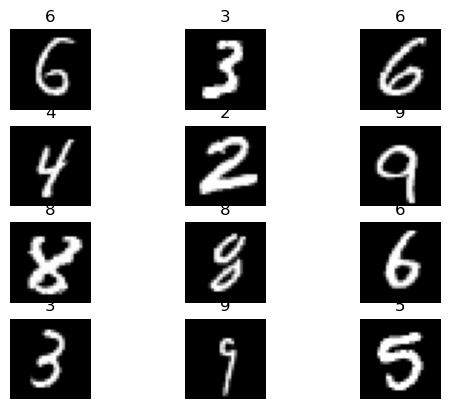

In [2]:
# visualizing data
t = train_data[3000][0].squeeze()
fig,axes = plt.subplots(4,3)




for i in range(12):
    ind = torch.randint(low=0,high=len(train_data),size=(1,)).item()
    img,label = train_data[ind]
    axes[i // 3][i % 3].imshow(img.squeeze(),cmap='grey')
    axes[i // 3][i % 3].axis("off")
    axes[i // 3][i % 3].set_title(label)


print(t.shape)
    
    


In [3]:
'''Training a neural net.

Now, we can use the useful batch function to train
our neural network to classify digits!
'''
from torch.utils.data import DataLoader
device = 'cuda'

# simple convolutional neural network
class CNN(nn.Module):
    def __init__(self,channels,im_dims,n_labels,hidden_size=200,device=device):
        super().__init__()
        # define channels, do conv net
        # accordingly
        self.layers = nn.ModuleList()
        
        for i in range(len(channels)-1):
            self.layers.append(nn.Conv2d(channels[i],channels[i+1],kernel_size=3,padding=1,device=device))
            self.layers.append(nn.ReLU())
        
        self.final_conv = nn.Conv2d(channels[-1],channels[0],kernel_size=1,padding=0)
        
        self.mlp = nn.Sequential(
            nn.Linear(im_dims[0]*im_dims[1]*channels[0],hidden_size,device=device),
            nn.GELU(approximate='tanh'),
            nn.Linear(hidden_size,n_labels,device=device)
        )
        
    def forward(self,x):
        
        for layer in self.layers:
            x = layer(x)
        x = self.final_conv(x)
        # B, C, H, W -> B,C*H*W
        x = x.view(x.shape[0],-1)
        x = self.mlp(x)
        
        # softmax
        # B,labels
        x = nn.functional.softmax(x,dim=-1)
        return x
    
    
model = CNN([1,3,6,3],[28,28],10)
model.to(device)
model.train()

# loss criterion, dataloader, optimizer
train_loader = DataLoader(train_data,128)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
epochs = 1


In [4]:
for i in range(epochs):
    print("Epoch:",i)
    running_loss = 0
    for batch in train_loader:
        # batch is image and label
        img,label = batch
        img,label = img.to(device),label.to(device)
        output = model(img)
        
        
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    print("Epoch-Loss:",running_loss)
    
    

Epoch: 0
Epoch-Loss: tensor(857.6600, device='cuda:0', grad_fn=<AddBackward0>)


In [5]:
# testing model output
# visualizing data
t = train_data[3000][0].squeeze()




for i in range(12):
    ind = torch.randint(low=0,high=len(test_data),size=(1,)).item()
    img,label = test_data[ind]
    print("Model-Assigned: ",model(img.to(device))[0][label])
    
    
# we have a model that can classify digits now.

Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.5873, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9761, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9962, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9958, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
Model-Assigned:  tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward0>)


In [6]:
'''Custom Dataset

1. Provide length and get_item, so torch can get batches,
and we can access it like a normal dataset

2. Init function, where we intialize the folder with the 
labels and their connected images

The dataloader we'll use is not going to use
labels at all.
'''
from dataloader import raw_images_convert

# downloading data
train_data = torchvision.datasets.CIFAR10(
    root = 'data',
    train = True,
    download=True
)

raw_images_convert(train_data,'hello','jpg',100)



Files already downloaded and verified
Path exists, process skipped


torch.Size([3, 32, 32])


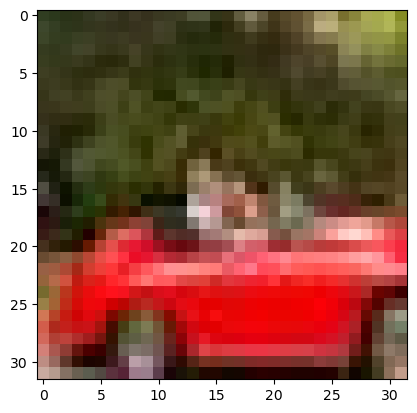

In [11]:
from dataloader import ImageDataset
# now, should be able to use with batches!

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.ToTensor()
])

# should load images from given path!
dataset = ImageDataset(transform,'hello','jpg')

print(dataset[80].shape)
plt.imshow(dataset[99].permute(1,2,0))

In [12]:
# testing latent-storage
from make_latents import store_latents

model_identity = lambda x: x

store_latents(dataset,'latent_folder',model_identity)

Mapping already exists, skipping latent-storage


[[tensor([[[0.2392, 0.1882, 0.2196,  ..., 0.6431, 0.6235, 0.6039],
         [0.0784, 0.0235, 0.0745,  ..., 0.5255, 0.5098, 0.4980],
         [0.0980, 0.0745, 0.1529,  ..., 0.4549, 0.4078, 0.3882],
         ...,
         [0.8549, 0.7608, 0.7765,  ..., 0.6353, 0.2353, 0.2314],
         [0.7490, 0.6745, 0.7137,  ..., 0.6706, 0.4078, 0.3373],
         [0.7490, 0.6745, 0.7255,  ..., 0.8039, 0.6157, 0.5059]],

        [[0.2471, 0.1765, 0.1647,  ..., 0.4902, 0.4745, 0.4549],
         [0.0784, 0.0039, 0.0118,  ..., 0.3804, 0.3686, 0.3529],
         [0.0784, 0.0392, 0.0784,  ..., 0.3255, 0.2824, 0.2627],
         ...,
         [0.6863, 0.6039, 0.6157,  ..., 0.5176, 0.1176, 0.1137],
         [0.5961, 0.5176, 0.5569,  ..., 0.5412, 0.2784, 0.2078],
         [0.5961, 0.5216, 0.5765,  ..., 0.6667, 0.4824, 0.3725]],

        [[0.2431, 0.1569, 0.1137,  ..., 0.3765, 0.3922, 0.3804],
         [0.0706, 0.0000, 0.0000,  ..., 0.2667, 0.2824, 0.2784],
         [0.0549, 0.0039, 0.0118,  ..., 0.2039, 0.1922, 

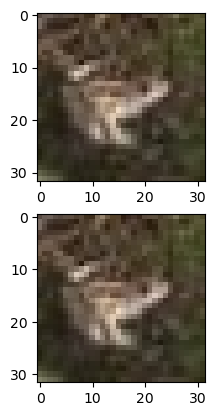

In [13]:
from dataloader import ImageDataset

# testing whether our latents worked
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32,32]),
    torchvision.transforms.ToTensor()
])

# now, loading both types of data
# to see if our latent-storer worked!
dataset1 = ImageDataset(transform,'hello','jpg',False)
dataset2 = ImageDataset(transform,'hello','jpg',True,'latent_folder')

fig,axes = plt.subplots(2,1)
axes[0].imshow(dataset1[22].permute(1,2,0))
axes[1].imshow(dataset2[22].permute(1,2,0))

##### Yay! We are now able to save latents, and use any images we want (we can even collect them ourselves :() )